Данные были взяты с Kaggle: https://www.kaggle.com/datasets/venkatasubramanian/automatic-ticket-classification.

Заказчик - **финтех компания**. Данные содержат информацию о жалобах пользователей этой компании.

Датасет содержит 78000 записей с 22 полями. Данные хранятся в формате json.

Жалобы не содержат разметку по теме / типу проблемы. Типы жалоб сформированы заказчиком. Всего их 5:
* Credit card / Prepaid card
* Bank account services
* Theft/Dispute reporting
* Mortgages/loans
* Others



**Что я сделал в этом проекте:**
* Подготовил среду к работе, отобрал полезные для анализа данные;
* Настроил пайплайн обработки текста (удаление лишних символов, токенизация, лемматизация, удаление pos-тегов);
* Провел разведовательный анализ данных, изучил количество символов в обработанных обращениях, изучил наиболее встречающиеся слова и словосочетания;
* Обучил 2 модели для моделирования тем (LDA, NMF) и сравнил результаты их работы;
* Обучил 4 модели классификации темы обращения (Logistic regression, SVC, CatBoostClassifier, ComplementNB) и сравнил результаты их работы;

Для загрузки данных необходимо загрузить файл `kaggle.json`. Скачать его можно из настроек своего аккаунта Kaggle.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


# Скачивание файла

После выполнения этой группы ячеек нужно перезапустить среду.

In [ ]:
!pip install kaggle catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d venkatasubramanian/automatic-ticket-classification

100% 14.0M/14.1M [00:01<00:00, 18.8MB/s]
100% 14.1M/14.1M [00:01<00:00, 11.1MB/s]


In [ ]:
!pip install pyldavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 22.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.0 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.12.0 r

# Подготовка данных

## Знакомство с данными

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import zipfile
import json
import re
import warnings

In [ ]:
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
with zipfile.ZipFile('/content/automatic-ticket-classification.zip') as myzip:
  print(myzip.namelist())

['complaints-2021-05-14_08_16_.json']


In [ ]:
with zipfile.ZipFile('/content/automatic-ticket-classification.zip') as myzip:
  with myzip.open('complaints-2021-05-14_08_16_.json') as myfile:
      data = json.load(myfile)
      df = pd.json_normalize(data)

In [ ]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

Необходимое мне поле - `19:  _source.complaint_what_happened`. В нем содержится текст обращения, с которым я буду работать. Результат команды `df.info()` показывает, что в этом поле нет пропущенных значений, однако за пустое значение эта команда считает `np.nan`. Это поле может содержать пустые строки, которые не считаются пропуском.

Формат записей в датасете:

In [ ]:
print(df.loc[1])

_index                                                                                                               complaint-public-v2
_type                                                                                                                          complaint
_id                                                                                                                              3229299
_score                                                                                                                               0.0
_source.tags                                                                                                               Servicemember
_source.zip_code                                                                                                                   319XX
_source.complaint_id                                                                                                             3229299
_source.issue                            

In [ ]:
df[df['_source.complaint_what_happened'] == ''].shape

(57241, 22)

Действительно, поле с текстом обращения содержит 57000 пустых строк. Работать с ними нельзя, поэтому я удалю эти записи из датасета.

In [ ]:
df['_source.complaint_what_happened'] = df['_source.complaint_what_happened'].replace({'':np.nan})
df = df[~df['_source.complaint_what_happened'].isnull()]

In [ ]:
df.shape

(21072, 22)

Осталась 21000 записей, с которыми можно работать.

## Очистка и подготовка текста

Для обработки текста, с ним нужно сделать несколько преобразований:
* Привести к нижнему регистру;
* Удалить пунктуацию и прочие символы;
* Удалить цифры;
* Лемматизировать слова - привести слова к их словарной форме;
* Удалить неинформативные части речи.

В данном датасете вся личная информация пользователей была заменена на "XXXX". Эти символы тоже нужно будет удалить.

In [ ]:
df['_source.complaint_what_happened'] = df['_source.complaint_what_happened'].astype(str)

In [ ]:
def clean_text(string:str):
  clean_string = ''
  clean_string = string.lower()
  clean_string = re.sub('[^\w\s]', '', clean_string) # удаление знаков препинания
  clean_string = re.sub('\w*\d\w', '', clean_string) # удаление слов с цифрами
  clean_string = re.sub('x+x', '', clean_string) # удаление анонимных персональных данных
  return clean_string

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag

lmzer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lemmatize_text(string:str):
  word_list = nltk.word_tokenize(string)
  word_list = [word for word in word_list if word not in stop_words] # удаление стоп-слов
  word_list = [lmzer.lemmatize(word) for word in word_list] # леммантизация
  pos_tags = pos_tag(word_list)
  lemmatized_output = ' '.join([pos_tag[0] for pos_tag in pos_tags if pos_tag[1] in ['NN', 'VB']]) # оставляем только имена существительные и глаголы
  return lemmatized_output

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Пример работы функций по очистке текста:

In [ ]:
i = 1

text = df.loc[i, '_source.complaint_what_happened']
cleaned = clean_text(text)
tokenized = lemmatize_text(cleaned)

pd.set_option('display.max_colwidth', None)
pd.DataFrame({'original_text':[text], 'cleaned_text':[cleaned], 'tokenized_text':[tokenized]})

,original_text,cleaned_text,tokenized_text
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account thanks in advance for your help,morning name appreciate help put stop chase bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help


Обработанный текст я выделю в новый датафрейм.

In [ ]:
complaints = pd.DataFrame()
complaints['text'] = df['_source.complaint_what_happened'].apply(clean_text)
complaints['text'] = complaints['text'].apply(lemmatize_text)
complaints.head()

,text
1,morning name appreciate help put stop chase bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,card agent date change agent information order upgrade account date consent agent
10,chase card application identity consent obtain service credit identity applicant
11,book ticket offer ticket card information offer minute decision made bank bank notification screen spoke application state information offer credit offer get account statement purchase ticket account application withdrawn representative application request proceed application chase fact credit account name credit report chase information credit report application consent error
14,son give check deposit chase account fund chase bank account money son check money bank refuse pay money son chase time call verify check owner country time date happen check number claim number chase


# EDA

## Исследование длины обработанных сообщений

In [ ]:
x = complaints['text'].apply(len)

fig = px.histogram(x, nbins=50, text_auto=True, title='Распределение длин обработанных обращений')
fig.show()

Большая часть строк имеет длинну менее 500 символов. Примерно 95% строк не превышает 1000 символов. Однако есть несколько обращений, к оторых даже после обработки остается больше 10000 символов.

In [ ]:
x = complaints['text'].apply(lambda x: len(x.split(' ')))

fig = px.histogram(x, nbins=50, text_auto=True, title='Распределение количества слов в обработанных сообщениях')
fig.show()

Большинство обработанных запросов содержит менее 50 слов. Около 95% не превышают 150 слов.

## WordCloud

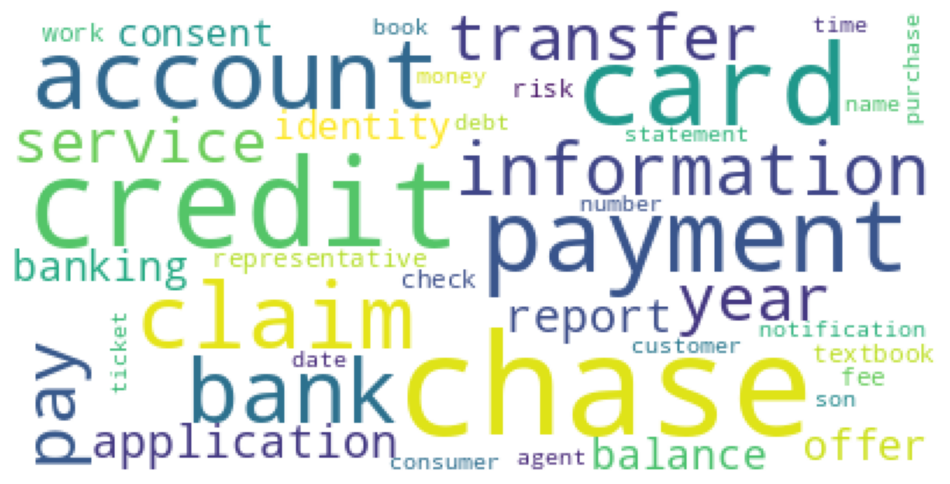

In [ ]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=40,
                      background_color="white", random_state=100,
                      stopwords=stopwords).generate(str(complaints['text']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

WorldCloud содержит обычные термины, встречающиеся в работе с финансами. Ничего интересного.

## Исследование частоты слов и словосочетаний

Искать n-граммы в тексте можно с помощью интрумента `CountVectorizer` библиотеки sklearn. Для удобства я напишу функцию.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(data, n=1, top=10):
  word_vectorizer = CountVectorizer(ngram_range=(n,n), analyzer='word')
  sparse_matrix = word_vectorizer.fit_transform(data)
  frequencies = sum(sparse_matrix).toarray()[0]
  frequencies = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names_out(), columns=['frequency'])
  return frequencies.sort_values(by='frequency', ascending=False).head(top)

In [ ]:
top_20_unigrams = get_top_ngrams(complaints['text'], n=1, top=20)

In [ ]:
fig = px.bar(top_20_unigrams, title='Наиболе часто встречающиеся слова в обработанных обращениях')
fig.show()

Наиболее частое слово - "chase". Это название банка.

In [ ]:
top_20_bigrams = get_top_ngrams(complaints['text'], n=2, top=20)

In [ ]:
fig = px.bar(top_20_bigrams, title='Наиболе часто встречающиеся биграммы в обработанных обращениях')
fig.show()

Словосочетание "credit card" смещает название банка на второе место. Похоже, что чаще всего люди обращаются с проблемами с кредитными картами. Помимо них, встречаются упоминания кредитной истории, службы поддержки клиентов и личного счета.

In [ ]:
top_20_trigrams = get_top_ngrams(complaints['text'], n=3, top=20)

In [ ]:
fig = px.bar(top_20_trigrams, title='Наиболе часто встречающиеся триграммы в обработанных обращениях')
fig.show()

Среди триграмм все еще лидируют вариации "credit card". Однако появилось и новое слово - "inquiry" (запрос) в "inquiry credit report".

# Обнаружение тем

## Обучение модели LDA

LDA (Latent Dirichlet allocation, Латентное размещение Дирихле) - модель, позволяющая объяснить сходство некоторых частей данных с помощью неявных (латентных) групп. В задаче тематического моделирования, этими группами являются темы документов, а документы - пересечение этих тем. Эта модель пытается выделить эти группы, основываясь на вероятность принадлежности некоторого слова из документа к группе.

Библиотека pyLDAvis, использующаяся для визуализации результатов работы модели LDA, конфликтует с некоторыми версиями pandas. После выполнения команды ниже проблемы проходят.

In [ ]:
!pip install pandas -U  #"pandas<2.0.0"

In [ ]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

texts = [t.split(' ') for t in complaints['text'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

# Train the model on the corpus
lda = LdaModel(common_corpus, num_topics=5, id2word=common_dictionary, passes=5, random_state=17)

In [ ]:
import pyLDAvis.gensim
import pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=lda, corpus=common_corpus, dictionary=common_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.128486 -0.002383       1        1  25.400450
2      0.017409  0.001846       2        1  24.228557
0     -0.038556  0.201387       3        1  20.038236
4      0.103137 -0.109164       4        1  15.474847
1     -0.210476 -0.091686       5        1  14.857910, topic_info=         Term          Freq         Total Category  logprob  loglift
29     credit  33805.000000  33805.000000  Default  30.0000  30.0000
21       card  27354.000000  27354.000000  Default  29.0000  29.0000
0     account  44734.000000  44734.000000  Default  28.0000  28.0000
91    payment  20506.000000  20506.000000  Default  27.0000  27.0000
128      loan  10775.000000  10775.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
0     account   3777.250575  44734.952718   Topic5  -3.8690  -0.5651
3        bank   1948.388582  28310.754013   Topic5  -4.5310  -0.7696
173  response   1067.509951   2842.139947   Topic5  -5.1327   0.9274
24       date   1138.865834   4948.519481   Topic5  -5.0680   0.4376
13       name   1090.848870   4079.189756   Topic5  -5.1110   0.5877

[392 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
313       1  0.819676  access
313       2  0.085155  access
313       3  0.004282  access
313       4  0.078495  access
313       5  0.012369  access
...     ...       ...     ...
138       2  0.260571    year
138       3  0.462524    year
138       4  0.029367    year
138       5  0.066774    year
563       5  0.979579       z

[795 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 5, 2])

Синие круги обозначают полученные темы. Они не пересекаются, и некоторые темы достаточно сильно удалены от других. К сожалению, номера на кругах не соответствуют номеру темы в полученной модели, что создает путаницу. Однако, эти темы все равно можно исследовать:
* **Тема 3** содержит все слова "loan" и "mortgage", встречающиеся в документах. Значит, это тема **"Mortgages / Loans"**.
* **Тема 4** содержит такие слова, как "fraud", "investigation", "overdraft". Должно быть, это тема **"Theft / Dispute reporting"**.
* **Тема 2** содержит больше всего слов "card" и "credit". Это тема **"Credit card / Prepaid card"**.
* **Тема 1** содержит такие слова, как "account", "check", "fund". Это тема **"Bank account services"**.
* Осталась только **тема 5**, и она должна быть темой **"Others"**.

Метрика 'Coherence Score' измеряет согласованность тем для тематических моделей.

In [ ]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=common_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4256897984964456


Согласованность тем примерно равна 0.43, а сами темы хорошо отличимы. Неплохой результат. Однако в процессе обучения результаты модельно сильно отличались на разных random_state, что в данном примере можно назвать минусом модели.

Пора посмотреть на темы модели и их характерные слова.

In [ ]:
x=lda.show_topics(num_topics=5, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

for topic,words in topics_words:
    print(f'topic_{topic}: {" ".join(words)}')

topic_0: payment chase loan mortgage home time year month bank pay
topic_1: credit report chase information letter account debt company inquiry consumer
topic_2: card credit chase charge account balance time service fee customer
topic_3: account bank chase check money day fund call deposit time
topic_4: chase transaction claim bank fraud charge account money card time


0. Mortgages/loans
1. Others
2. Credit card / Prepaid card
3. Bank account services
4. Theft/Dispute reporting







## Обучение модели NMF

Еще один способ моделирования тем - факторизация матрицы. Факторизация - процесс декомпозиции объекта в *факторы*, произведение которых дает исходный объект. Задача факторизация матрицы - поиск двух матриц, произведение которых будет давать исходную.

В задаче моделирования тем, за факторизируемую матрицу берется **терм-документная матрица** размерности NxM, где N - число документов в обучающем наборе, а M - число уникальных слов в документах. Ее факторами будут матрица *признаков* и матрица *компонент*. Матрица компонент имеет размер kxM, где k - число тем, и содержит "вес" слова в каждой теме. Матрица признаков имеет размер Nxk, и содержит в себе величину принадлежности документов к темам.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=2, # игнорировать слова, которые встреачются менее чем в 2 документах
                        max_df=0.95, # игнорировать слова, которые встречаются более чем в 95% документов
                        stop_words='english')

# Document Term Matrix
dtm = tfidf.fit_transform(complaints['text'])

Терм-документная матрица - способ предстваления документов в векторном виде. Эта матрица имеет размер NxM, где N - число документов в обучающем наборе, а M - число уникальных слов в документах. На пересечении i-ой строки и j-того столбца находится значение TF-IDF для слова j в документе i.

TF-IDF - статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов. Большой вес в TF-IDF получат слова с высокой частотой в пределах конкретного документа и с низкой частотой употреблений в других документах.

TF (term frequency — частота слова) — отношение числа появлений некоторого слова к общему числу слов в документе.

IDF (inverse document frequency — обратная частота документа) — инверсия частоты, с которой некоторое слово встречается в документах коллекции.

$TF \times IDF=TF-IDF$

In [ ]:
dtm

<21072x7587 sparse matrix of type '<class 'numpy.float64'>'
	with 648801 stored elements in Compressed Sparse Row format>

Полученный объект - sparse matrix, то есть разреженная матрица — матрица с преимущественно нулевыми элементами. Действительно, ведь в матрице целых 7587 уникальных слов, а большая часть документов содержит не более 50. А значение TF-IDF для слов, не встречающихся в документе, равно 0.

In [ ]:
1-(648801/(21072*7587))

0.9959417792333307

Больше 99% значений в этой матрице - нули.

Обучение модели NMF:

In [ ]:
from sklearn.decomposition import NMF

nmf_model = NMF(n_components=5, random_state=17)
nmf_model.fit(dtm)
nmf_features = nmf_model.transform(dtm)

In [ ]:
print('Размер терм-документной матрицы:', dtm.shape)
print('Размер матрицы признаков:', nmf_features.shape)
print('Размер матрицы компонентов:', nmf_model.components_.shape)

Размер терм-документной матрицы: (21072, 7587)
Размер матрицы признаков: (21072, 5)
Размер матрицы компонентов: (5, 7587)


Матрица компонентов содержит темы. Матрица признаков показывает принадлежность документа к теме.

Посмотрим на матрицу компонентов:

In [ ]:
components_df = pd.DataFrame(nmf_model.components_, columns=tfidf.get_feature_names_out())
components_df

,__,___,_____,aarp,ab,abandonment,abatement,abbreviation,abd,abet,...,youth,youve,yr,ytd,zero,zeroed,zip,zombie,zone,zoom
0,0.000043,0.000391,0.000246,0.000000,0.000000,0.000000,0.000000,0.000000,0.001233,0.000000,...,0.000777,0.001913,0.001295,0.000476,0.004762,0.000843,0.002111,0.000000,0.000751,0.000325
1,0.000214,0.000000,0.000136,0.004394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000213,...,0.000000,0.000748,0.001607,0.000000,0.002691,0.000211,0.002554,0.000503,0.000000,0.000047
2,0.000000,0.000160,0.000000,0.000000,0.001623,0.001504,0.001803,0.000855,0.000000,0.000535,...,0.000096,0.000722,0.018321,0.000000,0.002550,0.000350,0.004123,0.000486,0.003638,0.000000
3,0.000220,0.000082,0.000053,0.001182,0.000000,0.000000,0.000000,0.000085,0.000245,0.000028,...,0.000000,0.000578,0.002639,0.000698,0.002082,0.000212,0.004962,0.000000,0.001050,0.000197
4,0.000522,0.000000,0.000544,0.000000,0.000000,0.000000,0.000552,0.000000,0.000000,0.000000,...,0.000000,0.000387,0.004160,0.000035,0.002477,0.000801,0.004012,0.000000,0.000000,0.000000


Строки этой матрицы представляют темы, а значения ячеек - "вес" каждого слова в данной теме.

Посмотрим на слова с наибольшим весом в каждой теме:

In [ ]:
topic_words = {i:[] for i in range(components_df.shape[0])}

for topic,words in topic_words.items():
  tmp = components_df.iloc[topic]
  words.extend([*tmp.nlargest(10).index])

topic_words = pd.DataFrame(topic_words)
topic_words.index = [f'Word {i}' for i in range(10)]
topic_words.columns = [f'Topic {i}' for i in range(5)]
topic_words = topic_words.T
topic_words

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,account,bank,check,money,chase,fund,deposit,day,branch,number
Topic 1,credit,card,report,inquiry,chase,account,score,company,bureau,debt
Topic 2,loan,mortgage,home,chase,modification,property,year,rate,letter,time
Topic 3,charge,chase,transaction,card,dispute,fraud,claim,fee,merchant,purchase
Topic 4,payment,balance,month,fee,statement,pay,day,chase,time,auto


Полученные темы достаточно хорошо интерпретируются:
0. Bank account services
1. Credit card / Prepaid card
2. Mortgages/loans
3. Theft/Dispute reporting
4. Others







Модель NMF тоже имеет параметр `random_state`, однако результаты ее работы практически не отличались на разных значениях этого параметра, в отличие от модели LDA. Помимо этого, эта модель обучалась значительно быстрее LDA. Да и значения TF-IDF мне кажутся более правильным показателем веса слова, чем вероятность. Поэтому далее я буду использовать **темы, полученные моделью NMF**.

## Сопоставление тем и документов

Как было скзано ранее, матрица признаков показывает принадлежность документа к теме. Модель считает, что документы могут принадлежать к нескольким темам одновременно. Однако в этой задаче такое решения не подходит, поэтому для определения темы документа я буду брать наибольшее значение в каждой строке этой матрицы.

In [ ]:
pd.DataFrame(nmf_features).loc[0]

0    0.023519
1    0.012799
2    0.022366
3    0.011324
4    0.007408
Name: 0, dtype: float64

In [ ]:
complaints['topic'] = nmf_features.argmax(axis=1)
complaints

,text,topic
1,morning name appreciate help put stop chase bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,0
2,card agent date change agent information order upgrade account date consent agent,1
10,chase card application identity consent obtain service credit identity applicant,1
11,book ticket offer ticket card information offer minute decision made bank bank notification screen spoke application state information offer credit offer get account statement purchase ticket account application withdrawn representative application request proceed application chase fact credit account name credit report chase information credit report application consent error,1
14,son give check deposit chase account fund chase bank account money son check money bank refuse pay money son chase time call verify check owner country time date happen check number claim number chase,0
...,...,...
78303,chase card customer decade solicitation credit card chase bonus airline hotel point card fee year month payment chase card card chase harm credit fee account credit point airline hotel credit enrollment credit airline charge,1
78309,wednesday chas visa credit card provider claim purchase protection benefit school textbook year daughter school book water bottle backpack representative textbook covered file claim claim paperwork copy credit card statement copy receipt evidence damage book list item cover make claim insurance provider review information contact business day step process email claim submission complain representative claim day take day review claim information contradictory information email sent work adjuster put hold file claim textbook life revision course end course textbook purchase covered claim time call claim status find borderline fraudulent,3
78310,pay risk consumer chase bank chase year trust deal merchant merchant inquiry shut communication website look face brand individual medium consent research phone number information pi merchant account title holder perpetuate cycle fraud identity chase bank report report take recourse matter isnt place address issue app verbiage point position chase banking service entitlement customer service protection protocol chase link place consumer risk service flag concern chase minimum risk banking app made stand plan report authority identity inform neighbor work television news network risk banking fraud banking mogul chase action clicked extent better informed,3
78311,flawless credit chase credit card chase freedom problem balance transfer life experience balance transfer chase bill payment representative payment bc pay balance transfer fee payment balance standard rate advertise pay payment payment work chase pay agreement paperwork year everyone world card amt someone pay credit card bill pay chart payment percentage paperwork offer everyone term change term benefit wont budge payment refund transfer fee use transfer balance card payment transfer slate card min pmt work person like preserve credit transfer card id pay lump sum,4


Посмотри на количество документов в каждой теме:

In [ ]:
pd.DataFrame(nmf_features).idxmax(axis=1).value_counts(normalize=True)

0    0.247817
1    0.241363
3    0.225513
2    0.172077
4    0.113231
Name: proportion, dtype: float64

Дисбаланс классов небольшой: документов с темами 0, 1, 3 примерно одинаковое количество, немного меньше документов с темой 2, и меньше всего с темой 4.

Посмотрим на несколько документов и проверим точность назначенной темы:

In [ ]:
sample_idx = [1,2,57,30,58]
sample_complaints = []

for i in sample_idx:
  sample_complaints.append({'Complaint':df['_source.complaint_what_happened'].loc[i], 'Topic':complaints['topic'].loc[i]})

pd.DataFrame(sample_complaints)
# 0:'Bank account services', 1:'Credit card / Prepaid card', 2:'Mortgages/loans', 3:'Theft/Dispute reporting', 4:'Others'

,Complaint,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,1
2,I have been trying to do a loan modification with Chase and all they do is give me the runaround I'm 72 mo behind they dont let me make payments I have aens all doc in but always asking more,2
3,"To whom it may concern, Chase bank charged wrongly overdraft fees, I have alert of low balance or unsuficent fee balance and always deposit immediatly to cover transactions if needed but Chase always changed the order and charged me overdraft fee anyway. when you call they said their per their guidelines they don't refund more then 2 overdrawft doesn't matter bank fault or not.\n\nTaken {$34.00} from people is money just because you can is not Ok.\n\nSee attached documents. When Chase refund, they always find the way to take back what they refunded in first place.",3
4,"I made a purchase of {$260.00} on XX/XX/XXXX. I made payments of {$160.00} on XX/XX/XXXX and {$260.00} on XX/XX/XXXX. The minimum payment was {$140.00}. The closing date was XX/XX/XXXX ( please see attached statement ). That statement ( XX/XX/XXXX ) shows that I had an outstanding purchase balance of {$230.00} on XX/XX/XXXX. I have enclosed the previous months statement to show that there were NO other purchases prior to the one on XX/XX/XXXX. \nHowever, when I got the XXXX statement, it shows that I still have a purchase balance of {$210.00}. I have a promotional balance (@XXXX ) in XXXX of {$6900.00}. In XXXX, the promotional balance was {$7200.00} - a difference of {$380.00}. \n\nApparently, the payment ( above the minimum payment required by Chase ) I thought would be applied to the purchase (@ 21.49 % ) was applied to the promotional balance first. It is my understanding that once the minimum payment has been met, payments in excess of the minimum would be applied to the highest interest rate balance first. This is not the first time that Chase has skirted US Financial Law to turn a larger profit. I need help in rectifying this problem, because my logic fell on deaf ears at Chase. Thank you in advance for your assistance. \n\nRespectfully, XXXX XXXX XXXX",4


Содержимое документов и темы совпадают.

# Прогнозирование принадлежности к теме

Последний этап работы над проектом - обучение модели для классификации темы документа.

Для обучения необходимо:
* Разделить данные на обучающую и проверочную выборку;
* Вычислить терм-документную матрицу для обучающей выборки;
* Обучить модель, используя слова из матрицы как параметры;
* Преобразовать проверочную выборку в терм-документную матрицу;
* Сделать предсказания и оценить их качество.

Я хочу обучить несколько моделей - логистическую регрессию, SVM, градиентный бустинг и наивный байесовский классификатор.

Для удобства я буду обучать модели через пайплайн, который будет включать в себя само обучение и все предварительные этапы.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(complaints['text'],
                                                    complaints['topic'],
                                                    test_size=0.25,
                                                    random_state=17)

print('Train data: ', X_train.shape)
print('Test data: ', X_test.shape)

Train data:  (15804,)
Test data:  (5268,)


## Обучение LogisticRegression

Первая модель - LogisticRegression.

Хочется обратить внимание на то, что в метод `.fit()` пайплайна попадают только данные из обучающей выборки. Метод `.predict()` вызывает `.transform()` всех трансформеров в пайплайне на переданный набор данных, а потом вызывает `.predict()` моделью на последнем шаге. Никакого лика данных не происходит.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

lr_pipeline = make_pipeline(
    TfidfVectorizer(), # содержит в себе CountVectorizer() -> TfidfTransformer
    LogisticRegression(random_state=17, solver='newton-cg')
)

%time lr_pipeline.fit(X_train, y_train)

print(classification_report(y_test, lr_pipeline.predict(X_test)))

CPU times: user 3.47 s, sys: 1.97 s, total: 5.44 s
Wall time: 3.34 s
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1325
           1       0.97      0.96      0.97      1271
           2       0.96      0.97      0.97       854
           3       0.95      0.95      0.95      1184
           4       0.97      0.92      0.95       634

    accuracy                           0.96      5268
   macro avg       0.96      0.96      0.96      5268
weighted avg       0.96      0.96      0.96      5268



Всего за 3 секунды модель дала очень впечатляющий результат. Все метрики превышают 95% процентов, за исключением recall на 4 класс с величиной 0.92. Тем не менее, результат работы удовлетворительный.

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, lr_pipeline.predict(X_test))

fig = px.imshow(cm, text_auto=True, labels={'x':'Predicted label', 'y':'True label'}, title='Confusion Matrix for Logistic Regression')
fig.show()

## Обучение SupportVectorClassifier

Следующая модель - SVC. В процессе обучения у меня сложилось мнение, что метод опорных векторов - устаревшая и достаточно слабая модель. Но потом в одной из статей наткнулся на мнение, что такие модели очень хорошо себя показывают в задачах классификации текста. Сейчас я это и проверю.

In [ ]:
from sklearn.svm import SVC

svc_pipeline = make_pipeline(
    TfidfVectorizer(),
    SVC(kernel='linear', gamma='auto')
)

%time svc_pipeline.fit(X_train, y_train)

print(classification_report(y_test, svc_pipeline.predict(X_test)))

CPU times: user 25.7 s, sys: 33.2 ms, total: 25.7 s
Wall time: 26 s
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1325
           1       0.96      0.96      0.96      1271
           2       0.94      0.96      0.95       854
           3       0.94      0.94      0.94      1184
           4       0.95      0.90      0.93       634

    accuracy                           0.95      5268
   macro avg       0.95      0.95      0.95      5268
weighted avg       0.95      0.95      0.95      5268



Результат работы модели действительно впечатляет. Но обучалась она немного дольше логистической регрессии, а метрики немного меньше.

In [ ]:
cm = confusion_matrix(y_test, svc_pipeline.predict(X_test))

fig = px.imshow(cm, text_auto=True, labels={'x':'Predicted label', 'y':'True label'}, title='Confsuion Matrix for SVC')
fig.show()

## Обучение CatBoostClassifier

Следующая модель - CatBoostClassifier. Это одна из самых точных моделей, с которыми я работал. Посмотрим как она справится с этой задачей.

In [ ]:
from catboost import CatBoostClassifier

catb_pipeline = make_pipeline(
    TfidfVectorizer(),
    CatBoostClassifier(verbose=False)
)

%time catb_pipeline.fit(X_train, y_train)

print(classification_report(y_test, catb_pipeline.predict(X_test)))

CPU times: user 37min 57s, sys: 8.92 s, total: 38min 6s
Wall time: 27min 52s
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1325
           1       0.93      0.95      0.94      1271
           2       0.92      0.93      0.93       854
           3       0.93      0.91      0.92      1184
           4       0.94      0.90      0.92       634

    accuracy                           0.93      5268
   macro avg       0.93      0.93      0.93      5268
weighted avg       0.93      0.93      0.93      5268



После такого долгого обучения, результат работы модели не вызывает впечатления. Все метрики все еще больше 90%, но ниже чем у двух предыдущих.

In [ ]:
cm = confusion_matrix(y_test, catb_pipeline.predict(X_test))

fig = px.imshow(cm, text_auto=True, labels={'x':'Predicted label', 'y':'True label'}, title='Confusion Matrix for CatBoostClassifier')
fig.show()

## Обучение Complement Naive Bayes Classifier

Последняя модель, которую хочется попробовать - Наивный байесовский классификатор. Он вычисляет вероятность принадлежность объекта к классу по формуле Байеса. Для этого он вычисляет апостериорное распределение через максимизацию правдоподобия. Вероятность события (принадлежность к классу) и априорное распределение являются постоянными.

В библиотеке sklearn содержится несколько классов наивного байесовского классификатора с разными априорными распределениями. Я буду использовать ComplementNB - он имеет полиномиальное априорное распределение, но адаптирован под данные с дисбалансом классов.

In [ ]:
from sklearn.naive_bayes import ComplementNB

nb_pipeline = make_pipeline(
    TfidfVectorizer(),
    ComplementNB()
)

%time nb_pipeline.fit(X_train, y_train)

print(classification_report(y_test, nb_pipeline.predict(X_test)))

CPU times: user 1.36 s, sys: 0 ns, total: 1.36 s
Wall time: 1.4 s
              precision    recall  f1-score   support

           0       0.76      0.86      0.81      1325
           1       0.79      0.81      0.80      1271
           2       0.75      0.92      0.83       854
           3       0.81      0.78      0.79      1184
           4       0.87      0.40      0.55       634

    accuracy                           0.78      5268
   macro avg       0.80      0.75      0.76      5268
weighted avg       0.79      0.78      0.77      5268



Это самый худший результат из всех используемых моделей. Самая низкая метрика - recall для класса 4 (которого было меньше всего) - 0.4, из-за чего падает и f1-score. Остальные метрики находятся в пределах 0.75-0.85, с редкими исключениями.

In [ ]:
cm = confusion_matrix(y_test, nb_pipeline.predict(X_test))

fig = px.imshow(cm, text_auto=True, labels={'x':'Predicted label', 'y':'True label'}, title='Confusion Matrix for Naive Bayes Classifier')
fig.show()

# Заключение

В этом проекте я показал свои навыки работы с текстом и классификацией данных.

Для подготовки текста к анализу я привел его к нижнему регистру, удалил знаки препинания и цифры, провел токенизацию, лемматизацию, удалил неинформативные части речи.

Для моделирования тем я сравнил работу двух моделей - LDA и NMF. За свою стабильность, скорость и простоту, я выбрал модель **NMF** как лучшую модель для моделирования тем в этом примере.

Для классификации темы документа я подготовил пайплайн и сравнил работу четырех моделей - LogisticRegression, SVM, CatBoostClassifier и ComplementNB. Из-за своей скорости обучения и высоких метрик, я выбрал модель **LogisticRegression** как самую лучшую для этой задачи.

Обработка текста - очень полезный инструмент, который может быть применим для решения бизнес-задач из самых разных сфер бизнеса. Помимо анализа жалоб, можно также анализировать отзывы пользователей на товары, твиты или письма.


Минусом моделей LDA и NMF можно посчитать необходимость указывать точное количество тем. Нам не всегда известно количество тем в данных, а при анализе, например, новостных статей, количество тем может уходить за сотни. В таких задачах для моделирования тем можно использовать модель **BERTopic**.